In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import IPython.display as ipd
import matplotlib.pyplot as plt
import ppgs
import torch
import torchaudio

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint = promonet.RUNS_DIR / 'sppg-percentile-085' / 'generator-00400000.pt'

# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/w2v2fb/00200000.pt'

In [97]:
stems = promonet.load.partition('vctk')['test']
stem = random.choice(stems)
speakers = list(set(stem.split('/')[0] for stem in stems))
averages = promonet.load.per_speaker_averages()
speaker = stem.split('/')[0]
text = promonet.load.text(promonet.CACHE_DIR / 'vctk' / f'{stem}.txt')
audio = promonet.load.audio(promonet.CACHE_DIR / 'vctk' / f'{stem}-100.wav')
print(text)
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

We're not seeing an image of the person, he said.



### ProMoNet editing pipeline

In [99]:
def edit(
    condition,
    audio,
    speaker,
    target_speaker=None,
    edit_kwargs=None,
    synthesize_kwargs=None
):
    """Edit speech and plot the results"""
    if edit_kwargs is None:
        edit_kwargs = {}
    if synthesize_kwargs  is None:
        synthesize_kwargs = {}

    # Preprocess
    loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
        audio,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Edit
    (
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg
    )= promonet.edit.from_features(
        pitch,
        periodicity,
        loudness,
        ppg,
        **edit_kwargs)

    # Synthesize
    edited = promonet.synthesize.from_features(
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg,
        speaker=int(speaker),
        checkpoint=checkpoint,
        gpu=0,
        **synthesize_kwargs)
    
    # Plot and save results
    plot(
        condition,
        audio,
        edited,
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg)


def plot(
    condition,
    audio,
    edited,
    edited_pitch,
    edited_periodicity,
    edited_loudness,
    edited_ppg
):
    """Plot overlay of features from input and synthesized audio"""
    # Preprocess synthesized audio
    (
        predicted_loudness, 
        predicted_pitch,
        predicted_periodicity,
        predicted_ppg
    )= promonet.preprocess.from_audio(
        edited,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Make audio player
    ipd.display(ipd.Audio(audio.cpu(), rate=promonet.SAMPLE_RATE))
    ipd.display(ipd.Audio(edited.cpu(), rate=promonet.SAMPLE_RATE))

    # Make plot
    figure = promonet.plot.from_features(
        audio,
        edited_pitch,
        edited_periodicity,
        promonet.loudness.band_average(edited_loudness, 1),
        edited_ppg,
        predicted_pitch,
        predicted_periodicity,
        promonet.loudness.band_average(predicted_loudness, 1),
        predicted_ppg,
        features=['ppg', 'pitch', 'periodicity', 'loudness'])

    # Save
    figure.savefig(
        f'{condition}.png',
        bbox_inches='tight',
        pad_inches=0,
        transparent=True)
    torchaudio.save(f'{condition}-original.wav', audio.cpu(), promonet.SAMPLE_RATE)
    torchaudio.save(f'{condition}.wav', edited.cpu(), promonet.SAMPLE_RATE)

### Original

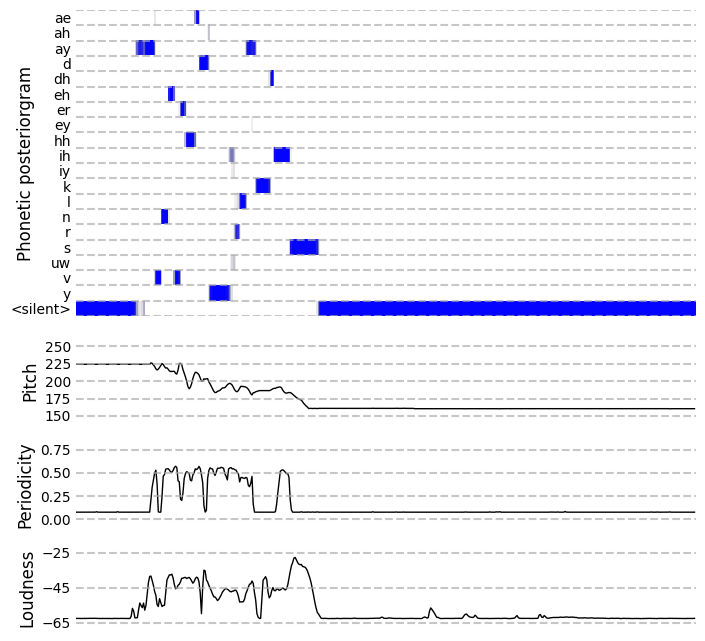

In [6]:
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
figure = promonet.plot.from_features(
    audio,
    pitch,
    periodicity,
    promonet.loudness.band_average(loudness, 1),
    ppg,
    features=['ppg', 'pitch', 'periodicity', 'loudness'])
figure.savefig(f'original.png', bbox_inches='tight', pad_inches=0, transparent=True)

### Reconstruction

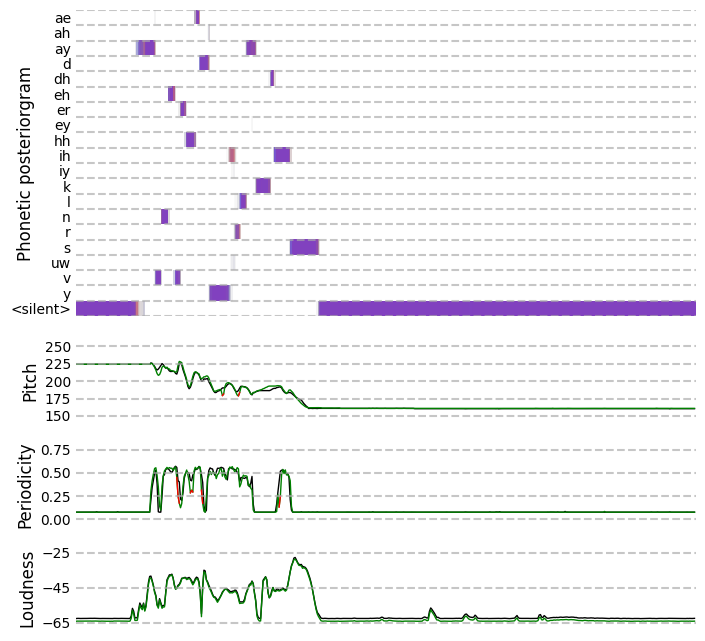

In [7]:
file = (
    promonet.EVAL_DIR /
    'subjective' /
    'mels-ours' /
    f'vctk-{stem.replace("/", "-")}-original-100.wav')
mel_audio = promonet.load.audio(file)
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
plot(
    'mel-reconstruction',
    audio,
    mel_audio,
    pitch,
    periodicity,
    loudness,
    ppg)

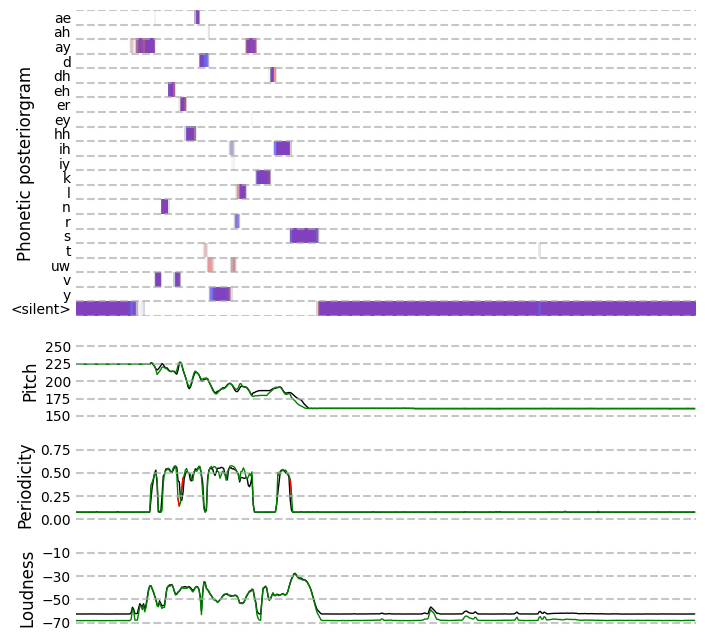

In [8]:
edit('reconstruction', audio, speaker)

### Pitch shifting

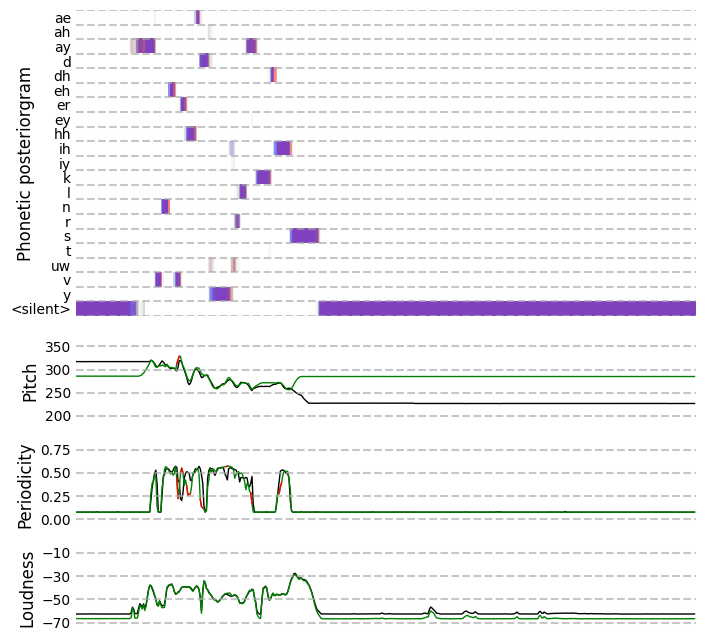

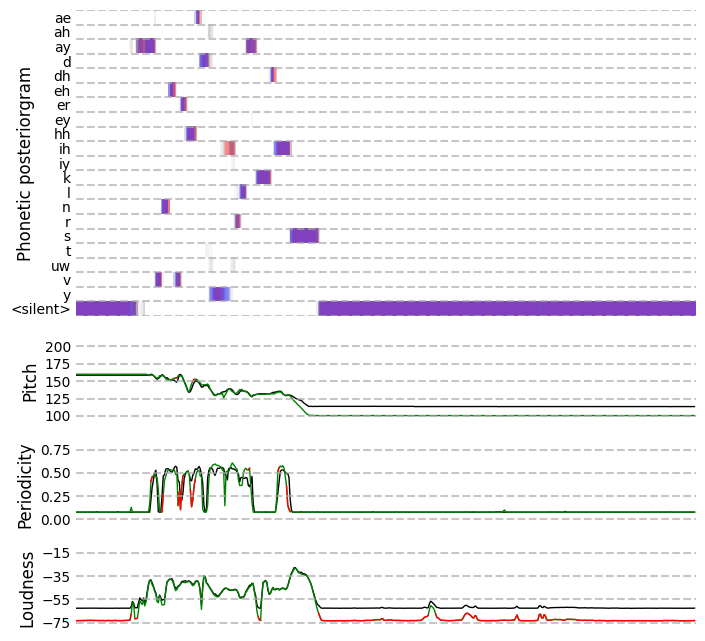

In [9]:
edit('shifted-141', audio, speaker, edit_kwargs={'pitch_shift_cents': 600.})
edit('shifted-071', audio, speaker, edit_kwargs={'pitch_shift_cents': -600.})

### Time-stretching

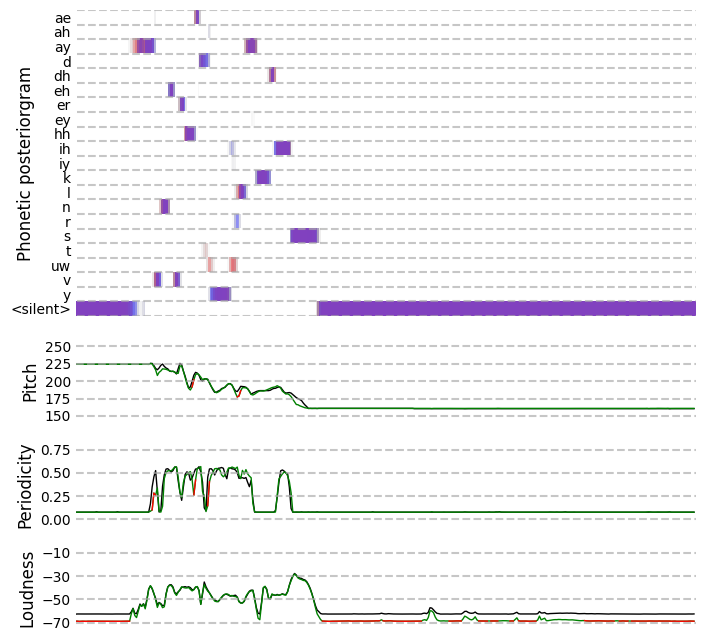

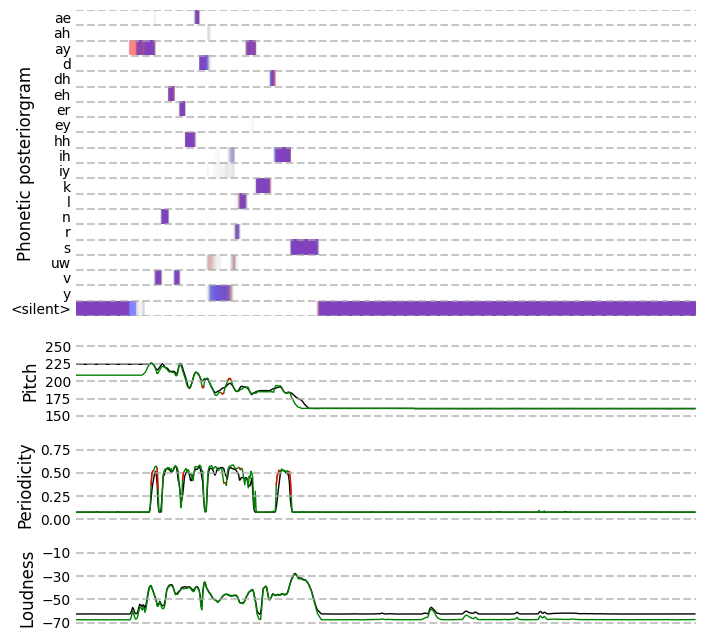

In [10]:
edit('stretched-141', audio, speaker, edit_kwargs={'time_stretch_ratio': 1.41})
edit('stretched-071', audio, speaker, edit_kwargs={'time_stretch_ratio': 0.71})

### Volume adjust

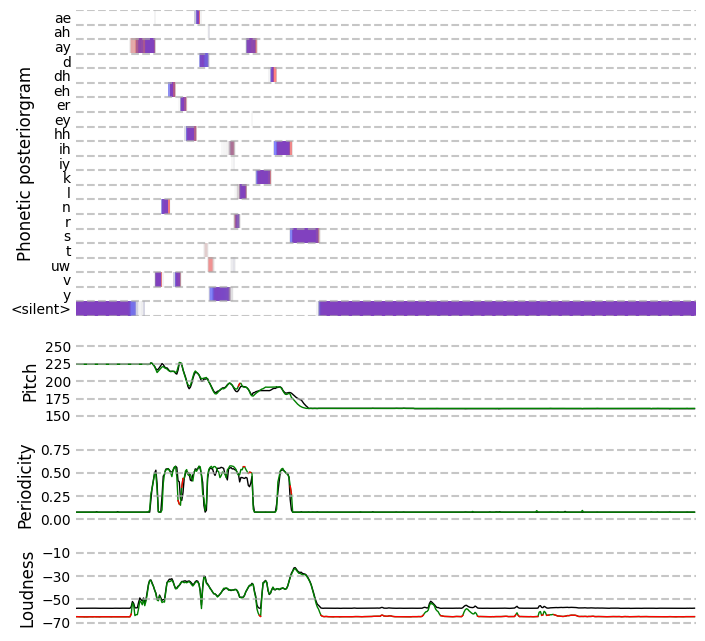

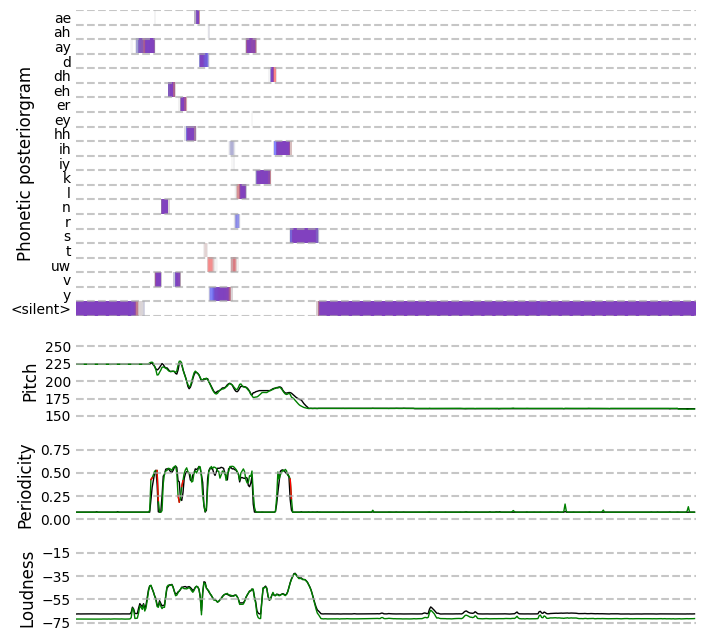

In [11]:
edit('volume-141', audio, speaker, edit_kwargs={'loudness_scale_db': promonet.convert.ratio_to_db(1.41)})
edit('volume-071', audio, speaker, edit_kwargs={'loudness_scale_db': promonet.convert.ratio_to_db(0.71)})

### Voice conversion

In [12]:
# Select a random target speaker
target_speaker = speaker
while target_speaker == speaker:
    target_speaker = random.choice(speakers)
mean_difference_cents = promonet.convert.ratio_to_cents(averages[target_speaker] / averages[speaker])
print(averages[speaker], averages[target_speaker], mean_difference_cents)
target_sample_stem = random.choice(
    [stem for stem in stems if stem.startswith(target_speaker)])
target_sample = promonet.load.audio(
    promonet.CACHE_DIR /
    'vctk' /
    f'{target_sample_stem}-100.wav')
ipd.display(ipd.Audio(target_sample.cpu(), rate=promonet.SAMPLE_RATE))
torchaudio.save(f'voice-conversion-target.wav', target_sample.cpu(), promonet.SAMPLE_RATE)

184.25529723803535 177.04341861701505 -69.12345886230462


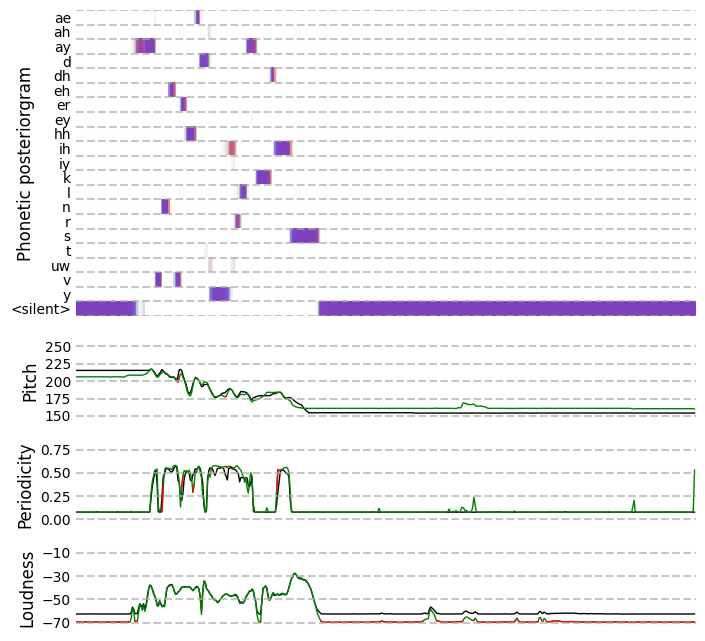

In [13]:
# Edit speaker
edit(
    'voice-conversion',
    audio,
    target_speaker,
    edit_kwargs={'pitch_shift_cents': mean_difference_cents})

### Formant editing

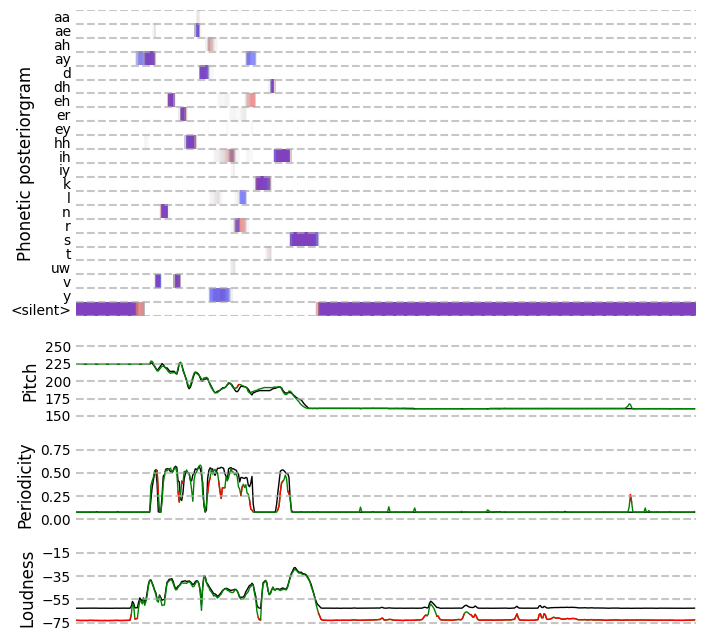

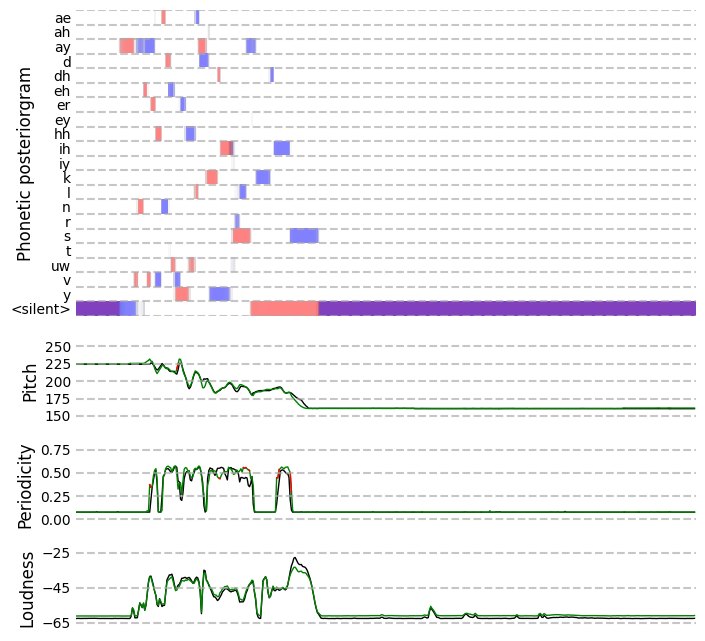

In [14]:
edit('formant-141', audio, speaker, synthesize_kwargs={'formant_ratio': 1.41})
edit('formant-071', audio, speaker, synthesize_kwargs={'formant_ratio': 0.71})

### Loudness editing

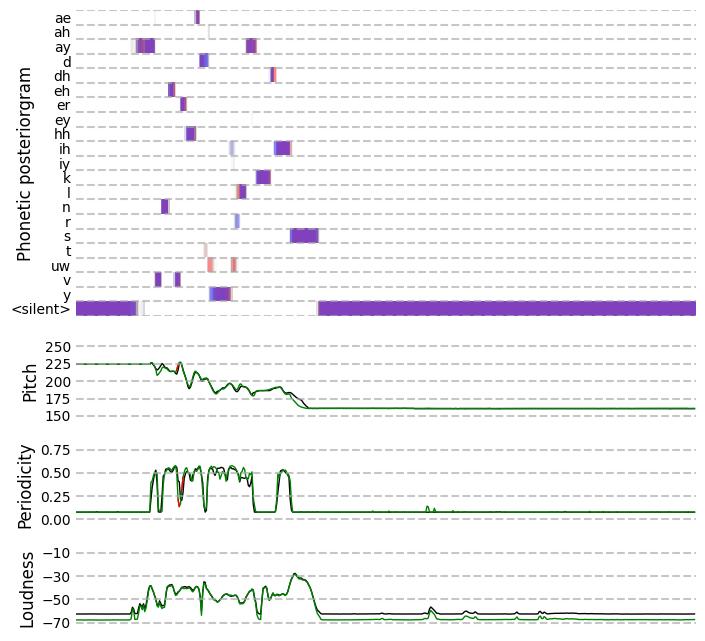

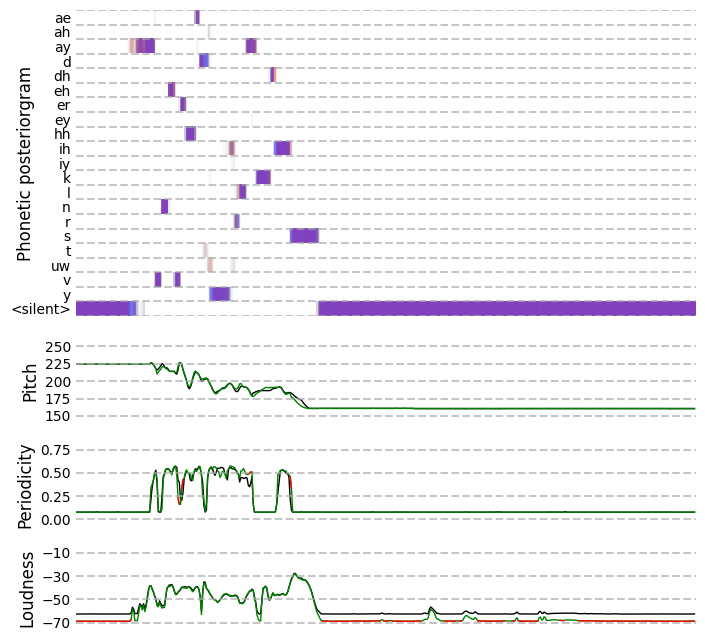

In [15]:
edit('loudness-141', audio, speaker, synthesize_kwargs={'loudness_ratio': 1.41})
edit('loudness-071', audio, speaker, synthesize_kwargs={'loudness_ratio': 0.71})

### Accent editing

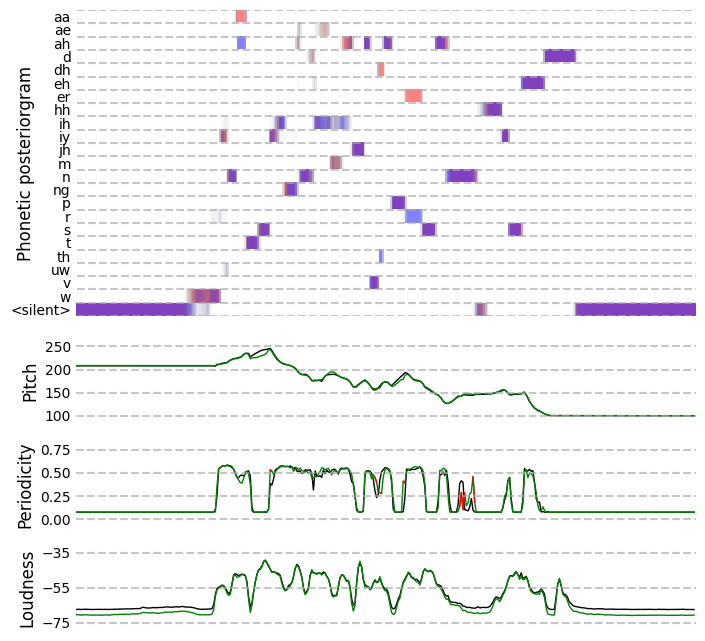

In [110]:
# audio = audio[..., :3 * promonet.SAMPLE_RATE]

# Preprocess
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)

# Edit
# edited_ppg = ppgs.edit.reallocate(ppg[0], 's', 'sh')[None]
# edited_ppg = ppgs.edit.swap(ppg[0], 'k', 'b')[None]
# edited_ppg = ppgs.edit.shift(ppg[0], 'eh', .2)[None]
# edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['hh', 'ae'], ['hh', 'aa'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['uw'], ['aa'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['ah'], ['uh'])[None].to('cuda:0')
# edited_ppg = ppgs.edit.reallocate(edited_ppg[0].cpu(), 'dh', 'th')[None].to('cuda:0')
edited_ppg = ppgs.edit.regex(ppg[0].cpu(), ['dh', 'ah'], ['th', 'ah'], reallocate=True)[None].to('cuda:0')
edited_ppg = ppgs.edit.regex(edited_ppg[0].cpu(), ['n', 'aa', 't'], ['n', 'ah', 't'], reallocate=True)[None].to('cuda:0')
edited_ppg = ppgs.edit.reallocate(edited_ppg[0], 'er', 'r')[None]
# edited_ppg = ppg

# Synthesize
edited = promonet.synthesize.from_features(
    pitch,
    periodicity,
    loudness,
    edited_ppg,
    speaker=int(speaker),
    checkpoint=checkpoint,
    gpu=0)

# Plot and save results
plot(
    'pronunciation',
    audio,
    edited,
    pitch,
    periodicity,
    loudness,
    edited_ppg)

In [49]:
pitch.device

device(type='cuda', index=0)

In [57]:
ppg[0,1]

tensor([1.8378e-08, 1.0155e-08, 1.0009e-08, 1.0014e-08, 1.0019e-08, 1.0028e-08,
        1.0021e-08, 1.0014e-08, 1.0009e-08, 1.0007e-08, 1.0007e-08, 1.0007e-08,
        1.0007e-08, 1.0010e-08, 1.0012e-08, 1.0019e-08, 1.0041e-08, 1.0086e-08,
        1.0156e-08, 1.0226e-08, 1.0234e-08, 1.0234e-08, 1.0204e-08, 1.0198e-08,
        1.0368e-08, 1.0971e-08, 1.2574e-08, 1.4146e-08, 1.4860e-08, 1.3353e-08,
        1.2018e-08, 1.2282e-08, 1.3190e-08, 1.7616e-08, 3.4780e-08, 8.9155e-08,
        2.5021e-07, 4.0084e-07, 4.4509e-07, 5.1532e-07, 8.4106e-07, 2.3167e-06,
        7.7111e-06, 1.9483e-05, 3.6724e-05, 3.2935e-05, 2.6954e-05, 3.3332e-05,
        5.5079e-05, 6.0901e-05, 7.2999e-05, 6.9524e-05, 6.1231e-05, 7.7676e-05,
        9.7653e-05, 1.0267e-04, 6.4326e-05, 2.6081e-05, 2.1121e-05, 1.5827e-05,
        6.8584e-05, 3.6420e-04, 5.1187e-03, 9.9785e-02, 9.0622e-02, 1.3246e-03,
        2.6916e-05, 2.1872e-06, 3.8167e-06, 1.4701e-05, 4.3099e-06, 6.2547e-07,
        1.0551e-07, 1.7268e-08, 1.0972e-